In [1]:
### DATA TREATMENT SECTION ###

from sys import exit
import importlib

from astropy.io.votable import is_votable, parse
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors
from matplotlib.markers import MarkerStyle

from stage2 import *

In [2]:
pathdata = "outputs/"
data     = ["matching_fieldGals_with_Zurich_acc_1_arcsec.vot", "master_field_galaxiesV2.vot"]

#Checking that file format is correct
for name in data:
    voTag = is_VOtable(pathdata+name)
    if voTag:        
        fullFileName = pathdata + name
        #Retrieving the data
        table = parse(fullFileName)
        full  = table.get_first_table()
        
        print("Size of", name, "is", full.array.shape[0], "\n")
    else:
        exit("Exiting")

The file outputs/matching_fieldGals_with_Zurich_acc_1_arcsec.vot is a VOtable, right ? True


Size of matching_fieldGals_with_Zurich_acc_1_arcsec.vot is 190 

The file outputs/master_field_galaxiesV2.vot is a VOtable, right ? True
Size of master_field_galaxiesV2.vot is 545 



In [3]:
#Getting data
matchWithZurich = parse(pathdata+data[0]).get_first_table().array
fieldGals       = parse(pathdata+data[1]).get_first_table().array

#Checking that the matching procedure did not duplicate galaxies
checkDupplicates([matchWithZurich, fieldGals], names=["matching_fieldGals_with_Zurich_acc_1_arcsec.vot", "master_field_galaxiesV2.vot"])

#Converting to an astropy table for simplicity
tableMatch = Table(matchWithZurich)        
tableField = Table(fieldGals)

#Checking that the maximum angular separation is less than 1 arcsec in the matching tableMatch
print("Maximum separation is", str((Table(matchWithZurich)['Separation']*u.arcsec).max()) + ".")
print("Mean separation is", str(np.mean(Table(matchWithZurich)['Separation']*u.arcsec)) + ".")
print("Median separation is", str(np.median(Table(matchWithZurich)['Separation']*u.arcsec)) + ".")
print("1st quantile is", str(np.quantile(Table(matchWithZurich)['Separation'], 0.25)*u.arcsec) + ".")
print("3rd quantile is", str(np.quantile(Table(matchWithZurich)['Separation'], 0.75)*u.arcsec) + ".\n")

#Remove galaxies which have wrong ID_Laigle_16 values (9999)
tableMatch = tableMatch[tableMatch['ID_Laigle_16'] != 9999]
tableField = tableField[tableField['ID_Laigle_16'] != 9999]

findWhereIsValue([tableMatch['ID_Laigle_16'], tableField['ID_Laigle_16']], 9999)

#Remove the galaxy counted twice in the array
arr, indices = np.unique(tableField['ID_Laigle_16'], return_index=True)
tableField   = tableField[indices]

print("\nNumber of galaxies in matching catalog:", np.shape(tableMatch)[0], 
      "\nNumber of galaxies in field catalog:", np.shape(tableField)[0])

#Split between galaxies with morphological data and without
mask              = np.in1d(tableField['ID_Laigle_16'], tableMatch['ID_Laigle_16'], assume_unique=True, invert=True)
galsWithoutMorpho = tableField[mask]

#Checking we have the right amount of galaxies
print("Number of gals without morpho:", np.shape(galsWithoutMorpho)[0],
      "\nNumber of gals with morpho + number without = initial total number ?", 
      np.shape(tableField)[0]==(np.shape(galsWithoutMorpho)[0]+np.shape(tableMatch)[0]))

All the galaxies are only listed once in the catalog matching_fieldGals_with_Zurich_acc_1_arcsec.vot
RA = 150.053047 deg and DEC = 2.604346 deg galaxy (line 6) is present more than once in catalog master_field_galaxiesV2.vot
RA = 150.053047 deg and DEC = 2.604346 deg galaxy (line 70) is present more than once in catalog master_field_galaxiesV2.vot
Maximum separation is 0.8778970454248154 arcsec.
Mean separation is 0.10395451693170249 arcsec.
Median separation is 0.06814922333003948 arcsec.
1st quantile is 0.04285471659041162 arcsec.
3rd quantile is 0.12246327531669089 arcsec.

No value 9999 found within array number 0
No value 9999 found within array number 1

Number of galaxies in matching catalog: 184 
Number of galaxies in field catalog: 489
Number of gals without morpho: 305 
Number of gals with morpho + number without = initial total number ? True


In [4]:
#Remove nan values
m                 = maskToRemoveVal([galsWithoutMorpho['lsfr']], astroTableMask=True)
galsWithoutMorpho = applyMask([galsWithoutMorpho], m)

m                 = maskToRemoveVal([tableMatch['lsfr']], astroTableMask=True)
tableMatch        = applyMask([tableMatch], m)

findWhereIsValue([galsWithoutMorpho['lsfr'], tableMatch['lsfr']])

No nan was found in array number 0
No nan was found in array number 1


In [5]:
tableMatch.dtype.names

('ID_Laigle_16',
 'RA',
 'DEC',
 'Z_MUSE',
 'CONFID',
 'Blend',
 'Defect',
 'Revisit',
 'ALPHA_J2000',
 'DELTA_J2000',
 'NUMBER',
 'X_IMAGE',
 'Y_IMAGE',
 'ERRX2_IMAGE',
 'ERRY2_IMAGE',
 'ERRXY_IMAGE',
 'FLAG_HJMCC',
 'FLUX_RADIUS',
 'KRON_RADIUS',
 'EBV',
 'FLAG_PETER',
 'FLAG_COSMOS',
 'FLAG_DEEP',
 'FLAG_SHALLOW',
 'Ks_FLUX_APER2',
 'Ks_FLUXERR_APER2',
 'Ks_FLUX_APER3',
 'Ks_FLUXERR_APER3',
 'Ks_MAG_APER2',
 'Ks_MAGERR_APER2',
 'Ks_MAG_APER3',
 'Ks_MAGERR_APER3',
 'Ks_MAG_AUTO',
 'Ks_MAGERR_AUTO',
 'Ks_MAG_ISO',
 'Ks_MAGERR_ISO',
 'Ks_FLAGS',
 'Ks_IMAFLAGS_ISO',
 'Y_FLUX_APER2',
 'Y_FLUXERR_APER2',
 'Y_FLUX_APER3',
 'Y_FLUXERR_APER3',
 'Y_MAG_APER2',
 'Y_MAGERR_APER2',
 'Y_MAG_APER3',
 'Y_MAGERR_APER3',
 'Y_MAG_AUTO',
 'Y_MAGERR_AUTO',
 'Y_MAG_ISO',
 'Y_MAGERR_ISO',
 'Y_FLAGS',
 'Y_IMAFLAGS_ISO',
 'H_FLUX_APER2',
 'H_FLUXERR_APER2',
 'H_FLUX_APER3',
 'H_FLUXERR_APER3',
 'H_MAG_APER2',
 'H_MAGERR_APER2',
 'H_MAG_APER3',
 'H_MAGERR_APER3',
 'H_MAG_AUTO',
 'H_MAGERR_AUTO',
 'H_MAG_ISO'

Not enough labels were given compared to data dimension. Printing empty strings instead.
Data from matching catalog
Without correction: scatter = 1.2970091918676652 dex
With correction: scatter = 0.6290032859531153 dex

Data from MUSE catalog
Without correction: scatter = 1.3085576918053483 dex
With correction: scatter = 0.6246786114323394 dex


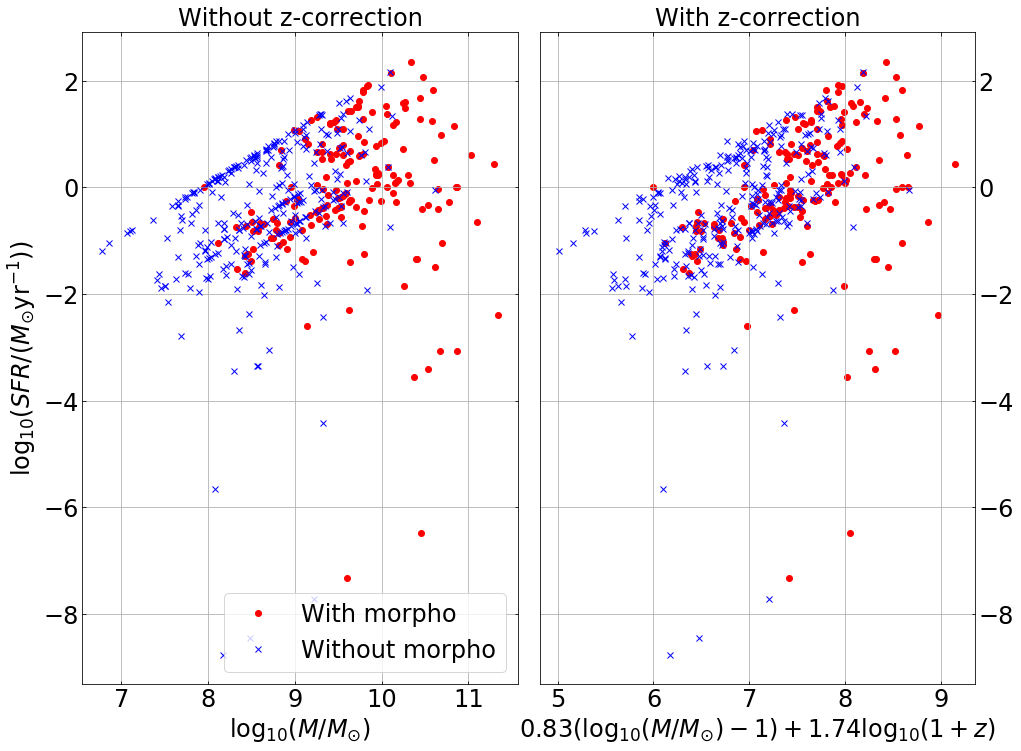

In [8]:
#Plotting log(SFR) against log(mass)

plt.rcParams["figure.figsize"] = (16, 12) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.05, hspace=0.05)

#custom color map for gals with morpho
newcmap, norm = from_levels_and_colors([0.5, 1.5, 2.5, 3.5], ['blue', 'green', 'red'])

ax1, tmp = asManyPlots(121, [tableMatch['lmass'], galsWithoutMorpho['lmass']], 
                       [tableMatch['lsfr'], galsWithoutMorpho['lsfr']],
                       label=['With morpho', 'Without morpho'], showLegend=True,
                       xlabel=r'$\log_{10} ( M/M_{\odot})$', ylabel=r'$\log_{10} (SFR/(M_{\odot} \rm{yr}^{-1}))$',
                       marker=['o', 'x'], zorder=[1, 2], color=['r', 'b'],
                       title='Without z-correction')

xdata = [0.83*(tableMatch['lmass']-1.0)+1.74*np.log10(1.0+tableMatch['Z_MUSE']), 
         0.83*(galsWithoutMorpho['lmass']-1.0)+1.74*np.log10(1.0+galsWithoutMorpho['Z_MUSE'])]
ax1, tmp = asManyPlots(122, xdata, 
                       [tableMatch['lsfr'], galsWithoutMorpho['lsfr']],
                       xlabel=r'$0.83( \log_{10} ( M/M_{\odot}) -1)+1.74 \log_{10} ( 1 + z) $', ylabel=r'$\log_{10} (SFR/(M_{\odot} \rm{yr}^{-1}))$',
                       marker=['o', 'x'], zorder=[1, 2], color=['r', 'b'],
                       placeYaxisOnRight=True, hideYlabel=True, title='With z-correction')

print("Data from matching catalog\nWithout correction: scatter =", np.std(tableMatch['lsfr']), 
      "dex\nWith correction: scatter =", np.std(0.83*(tableMatch['lmass']-1.0)+1.74*np.log10(1.0+tableMatch['Z_MUSE'])),
      "dex\n\nData from MUSE catalog\nWithout correction: scatter =", np.std(galsWithoutMorpho['lsfr']),
      "dex\nWith correction: scatter =", np.std(0.83*(galsWithoutMorpho['lmass']-1.0)+1.74*np.log10(1.0+galsWithoutMorpho['Z_MUSE'])),
      "dex")